CryoJAX is built to support new image simulation methods external to the main codebase. To achieve this, cryoJAX models and algorithms--e.g. for volumes, CTFs, and poses--are built on abstract base classes.

To name a few, the following table outlines abstract base classes for key modeling components in cryoJAX:

| Modeling component | Abstract base class |
| :----------------- | :------------------ |
| Model image formation | `AbstractImageModel` |
| Represent a volume for imaging | `AbstractVolumeRepresentation` |
| Project an `AbstractVolumeRepresentation` on imaging plane  | `AbstractVolumeIntegrator` |
| Contrast transfer functions | `AbstractCTF` |
| Pose | `AbstractPose` |

To see what exactly needs to be implemented for a particular abstract base class, it is necessary to read the cryoJAX documentation or source code.

In this tutorial it is demonstrated how to extend the `AbstractCTF` class for use with other existing image simulation code. A simple model for defocus and spherical aberration will be implemented with aberration function $\chi$ as

$$\chi(\vec{q}) = -\pi \lambda \Delta f |\vec{q}|^2 + \frac{\pi}{2} \lambda^3 C_s |\vec{q}|^4,$$

where $\vec{q}$ is an in-plane spatial frequency vector, $\lambda$ is wavelength, $\Delta f$ is defocus, and $C_s$ is the spherical aberration coefficient. 

In [1]:
# Plotting imports and functions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, cmap="gray", label=None, **kwargs):
    fig, ax = plt.subplots(figsize=(3, 3))
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [2]:
# Start with building other image simulation components
import cryojax.simulator as cxs
import equinox as eqx
import jax
from cryojax.io import read_array_from_mrc


jax.config.update("jax_enable_x64", True)

# ... scattering potential stored in MRC format
filename = "./data/groel_5w0s_scattering_potential.mrc"
# ... read into a FourierVoxelGridPotential
real_voxel_grid, voxel_size = read_array_from_mrc(filename, loads_grid_spacing=True)
volume = cxs.FourierVoxelGridVolume.from_real_voxel_grid(real_voxel_grid, pad_scale=2)
# ... instantiate the pose. Angles are given in degrees
pose = cxs.EulerAnglePose(
    offset_x_in_angstroms=5.0,
    offset_y_in_angstroms=-3.0,
    phi_angle=20.0,
    theta_angle=80.0,
    psi_angle=-5.0,
)
# ... the configuration. Add padding with respect to the final image shape.
pad_options = dict(shape=volume.shape[0:2])
config = cxs.BasicImageConfig(
    shape=(80, 80),
    pixel_size=voxel_size,
    voltage_in_kilovolts=300.0,
    pad_options=pad_options,
)


# Now, define function for image simulation
@eqx.filter_jit
def simulate_fn(ctf: cxs.AbstractCTF, ac: float, args: tuple) -> jax.Array:
    volume, config, pose = args
    transfer_theory = cxs.ContrastTransferTheory(ctf=ctf, amplitude_contrast_ratio=ac)
    image_model = cxs.make_image_model(
        volume,
        config,
        pose,
        transfer_theory,
        normalizes_signal=True,
    )
    return image_model.simulate()

First, just the defocus term of the CTF will be implemented. To do so, the interface for an `AbstractCTF` must be implemented. The jist of what this looks like is the following:

```python
class AbstractCTF(eqx.Module, strict=True):
    """An abstract base class for a CTF in cryo-EM."""

    @abstractmethod
    def compute_aberration_phase_shifts(
        self,
        frequency_grid_in_angstroms,
        wavelength_in_angstroms,
        defocus_offset=None,
    ):
        raise NotImplementedError
```

There is a single `abstractmethod` to implement for the aberration function $\chi$.

In [3]:
import cryojax.simulator as cxs
import jax
import jax.numpy as jnp
from cryojax.jax_util import NDArrayLike


class CustomCTF(cxs.AbstractCTF):  # First, subclass `AbstractCTF`
    defocus_in_angstroms: jax.Array  # Next, parameters are `dataclass` fields

    def __init__(self, defocus_in_angstroms: float | jax.Array):
        self.defocus_in_angstroms = jnp.asarray(defocus_in_angstroms, dtype=float)

    def compute_aberration_phase_shifts(
        self,
        frequency_grid_in_angstroms: jax.Array,
        wavelength_in_angstroms: float | NDArrayLike,
        defocus_offset: float | NDArrayLike | None = None,
    ) -> jax.Array:
        """Finally, implement the interface defined by `AbstractCTF`"""
        q_squared = jnp.sum(frequency_grid_in_angstroms**2, axis=-1)
        defocus = self.defocus_in_angstroms
        if defocus_offset is not None:
            defocus += defocus_offset
        return -jnp.asarray(jnp.pi * wavelength_in_angstroms * defocus * q_squared)

!!! info "How do classes work in cryoJAX?"
    Classes in cryoJAX are built on [`equinox.Module`s](https://docs.kidger.site/equinox/api/module/module/#module). These are reminiscent of a PyTorch `torch.nn.Module`, but also have python `dataclass`-like features and smoothly integrate with JAX functional programming.

    CryoJAX's abstract base class paradigm is inspired from other libraries in the JAX+Equinox ecosystem. To learn more, see [`lineax`](https://docs.kidger.site/lineax/), [`optimistix`](https://docs.kidger.site/optimistix/), and [`diffrax`](https://docs.kidger.site/diffrax/). 

(<Figure size 300x300 with 2 Axes>, <Axes: >)

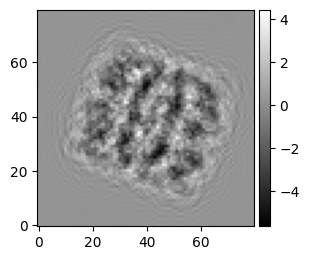

In [4]:
# Now, simulate an image using our `CustomCTF`
args = (volume, config, pose)
custom_ctf = CustomCTF(defocus_in_angstroms=10_000)  # 1 um defocus
image_1 = simulate_fn(custom_ctf, ac=0.1, args=args)
plot_image(image_1)

In [5]:
# This image should be identical to cryoJAX's built-in CTF at zero
# astigmatism and spherical aberration!
builtin_ctf = cxs.AstigmaticCTF(
    defocus_in_angstroms=10_000,
    spherical_aberration_in_mm=0.0,
    astigmatism_in_angstroms=0.0,
)
test_image_1 = simulate_fn(builtin_ctf, ac=0.1, args=args)
assert jnp.allclose(image_1, test_image_1)

That was easy! Implementing abstract interfaces is the most important concept to know for extending cryoJAX, but it is also possible to modify existing implementations by wrapping *existing* implementations. To demonstrate this, we can modify the `CustomCTF` to also include a spherical aberration term.

In [6]:
class WrappedCTF(cxs.AbstractCTF):  # Implement a new `AbstractCTF`
    ctf: CustomCTF  # Wrap the `CustomCTF`
    spherical_aberration_in_mm: jax.Array

    def compute_aberration_phase_shifts(
        self,
        frequency_grid_in_angstroms,
        wavelength_in_angstroms,
        defocus_offset=None,
    ):
        q_squared = jnp.sum(frequency_grid_in_angstroms**2, axis=-1)
        Cs = 1e7 * self.spherical_aberration_in_mm  # mm to Angstroms
        # Compute the `CustomCTF`` aberration function
        chi = self.ctf.compute_aberration_phase_shifts(
            frequency_grid_in_angstroms, wavelength_in_angstroms, defocus_offset
        )
        # Modify output to include spherical aberration term
        chi += (jnp.pi / 2) * Cs * wavelength_in_angstroms**3 * q_squared**2
        return chi

(<Figure size 300x300 with 2 Axes>, <Axes: >)

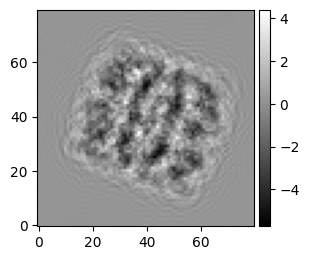

In [7]:
# Simulate an image using the `WrappedCTF`
args = (volume, config, pose)
wrapped_ctf = WrappedCTF(ctf=custom_ctf, spherical_aberration_in_mm=2.7)
image_2 = simulate_fn(wrapped_ctf, ac=0.1, args=args)
plot_image(image_2)

In [8]:
# Again, confirm that this is the same as the native cryoJAX implementation
builtin_ctf = cxs.AstigmaticCTF(
    defocus_in_angstroms=10_000,
    spherical_aberration_in_mm=2.7,
    astigmatism_in_angstroms=0.0,
)
test_image_2 = simulate_fn(builtin_ctf, ac=0.1, args=args)
assert jnp.allclose(image_2, test_image_2)

While this is a toy example, the principle applies generally in cryoJAX and is meant to support an ecosystem of cryo-EM research projects. For example, one can implement custom volumes via the `AbstractVolumeRepresentation` and `AbstractVolumeIntegrator` interfaces to model particular proteins or parametrize conformational heterogeneity.

What next? There is a wide range of possible image formation modeling in cryoJAX to learn about. For example, other useful abstract interfaces include the following:

| Modeling component | Abstract base class |
| :----------------- | :------------------ |
| Function returning an `AbstractVolumeRepresentation` | `AbstractVolumeParametrization` |
| Noise models | `AbstractNoiseModel` |
| Filters and masks | `AbstractFilter` and `AbstractMask` |
| Scattering approximations | `AbstractScatteringTheory` |
| Detectors and DQEs | `AbstractDetector` and `AbstractDQE` |